In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys                                             # Module to see files and folders in directories

import pm4py

from fitter import Fitter, get_common_distributions
from distfit import distfit
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.objects.log.util import dataframe_utils
from itertools import chain, combinations
from scipy.stats import expon, lognorm, norm, poisson, uniform
import numpy as np
import matplotlib as mpl                # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit,cost                             # The actual fitting tool, better than scipy's
from scipy import stats
import pandas as pd

from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.mixture import GaussianMixture

r = np.random                         # Random generator
r.seed(1)                            # Set a random seed (but a fixed one - more on that later.)

save_plots = False

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

from IPython.display import clear_output

In [9]:
from fit_human_in_the_loop import MinuitFitFunctions
import fit_human_in_the_loop

In [17]:
# log = pm4py.read_xes('/home/vco/Projects/pm4py-dcr4py/tests/input_data/roadtraffic50traces.xes')
sepsis = "Sepsis_Cases_ Event_Log.xes"
log = pm4py.read_xes(f'/home/vco/Datasets/{sepsis}')

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2434.72it/s]


In [18]:
graph, timings = pm4py.discover_dcr(log,post_process={'timed'})

In [28]:
# Nbins = 100
# xmin = 0
# xmax = 800

data_dict = {}

for k,v in timings.items():
    data_seconds = np.array([s.total_seconds()/(60*60*24) for s in v])
    Nbins, binwidth = MinuitFitFunctions.freedman_diaconis_rule(data_seconds)
    xmin = min(data_seconds)
    xmax = max(data_seconds)
    counts, bin_edges = np.histogram(data_seconds, bins=Nbins,range=(xmin,xmax))
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
    data_dict[k] = [data_seconds,Nbins,x,y,sy,binwidth]

In [29]:
timing_results = pd.DataFrame(columns=['Rule','EventFrom','EventTo','Function','Parameters'])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.5196                     │              Nfcn = 459              │
│ EDM = 3.41e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

2025-07-31 11:39:26.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000907)
2025-07-31 11:39:26.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.013202)
2025-07-31 11:39:26.638 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000311)
2025-07-31 11:39:26.639 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.004823)
2025-07-31 11:39:26.642 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.006777)
2025-07-31 11:39:26.646 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.005257)
2025-07-31 11:39:26.651 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000985)
2025-07-31 11:39:26.675 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

          sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon            0.000311  118.145211  122.195914     inf      0.094209   
lognorm          0.000907  116.470669  122.546724     inf      0.084104   
cauchy           0.000985  125.922437  129.973140     inf      0.218477   
exponpow         0.001061  121.608291  127.684346     inf      0.100884   
chi2             0.003107  189.391358  195.467413     inf      0.332846   

          ks_pvalue  
expon      0.667810  
lognorm    0.792012  
cauchy     0.007932  
exponpow   0.583593  
chi2       0.000005  
{'expon': {'loc': 0.11012731481481482, 'scale': 6.926724123677249}}
expon
expon
[[ 5.20890134]
 [38.93756929]
 [ 1.37020149]
 [11.7923841 ]]


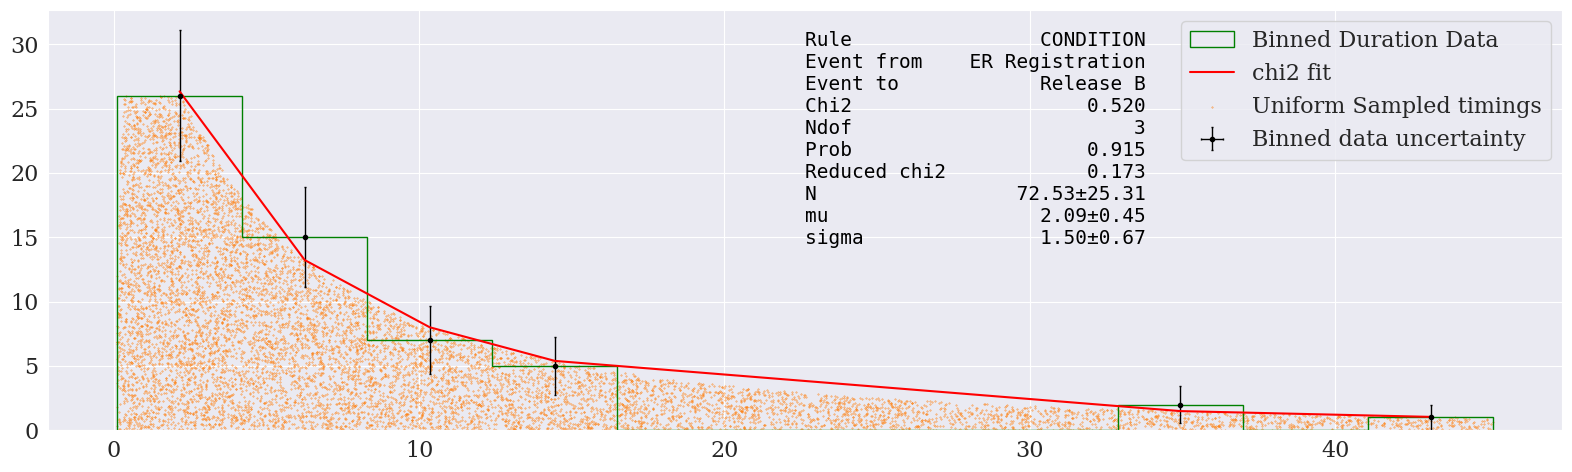

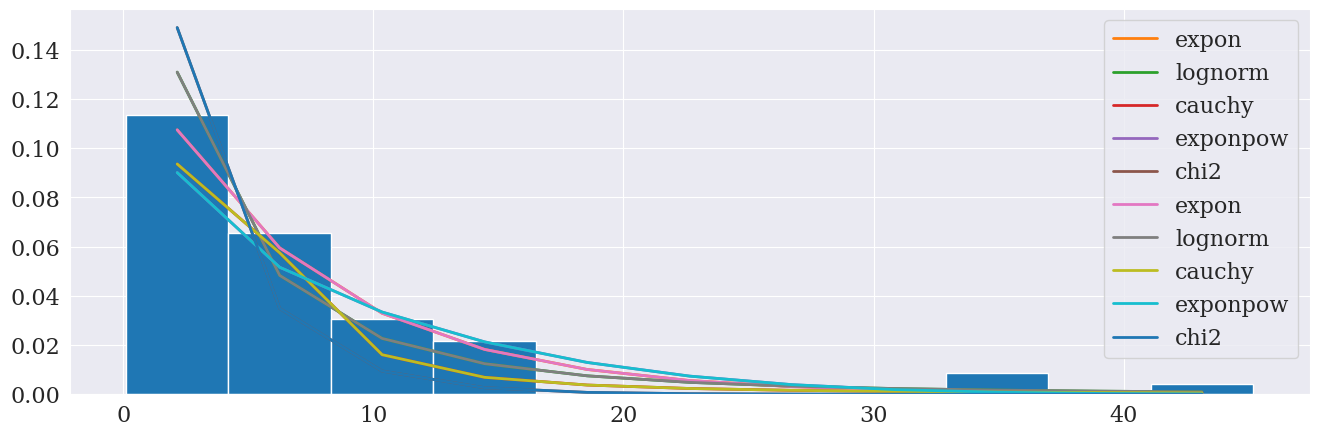

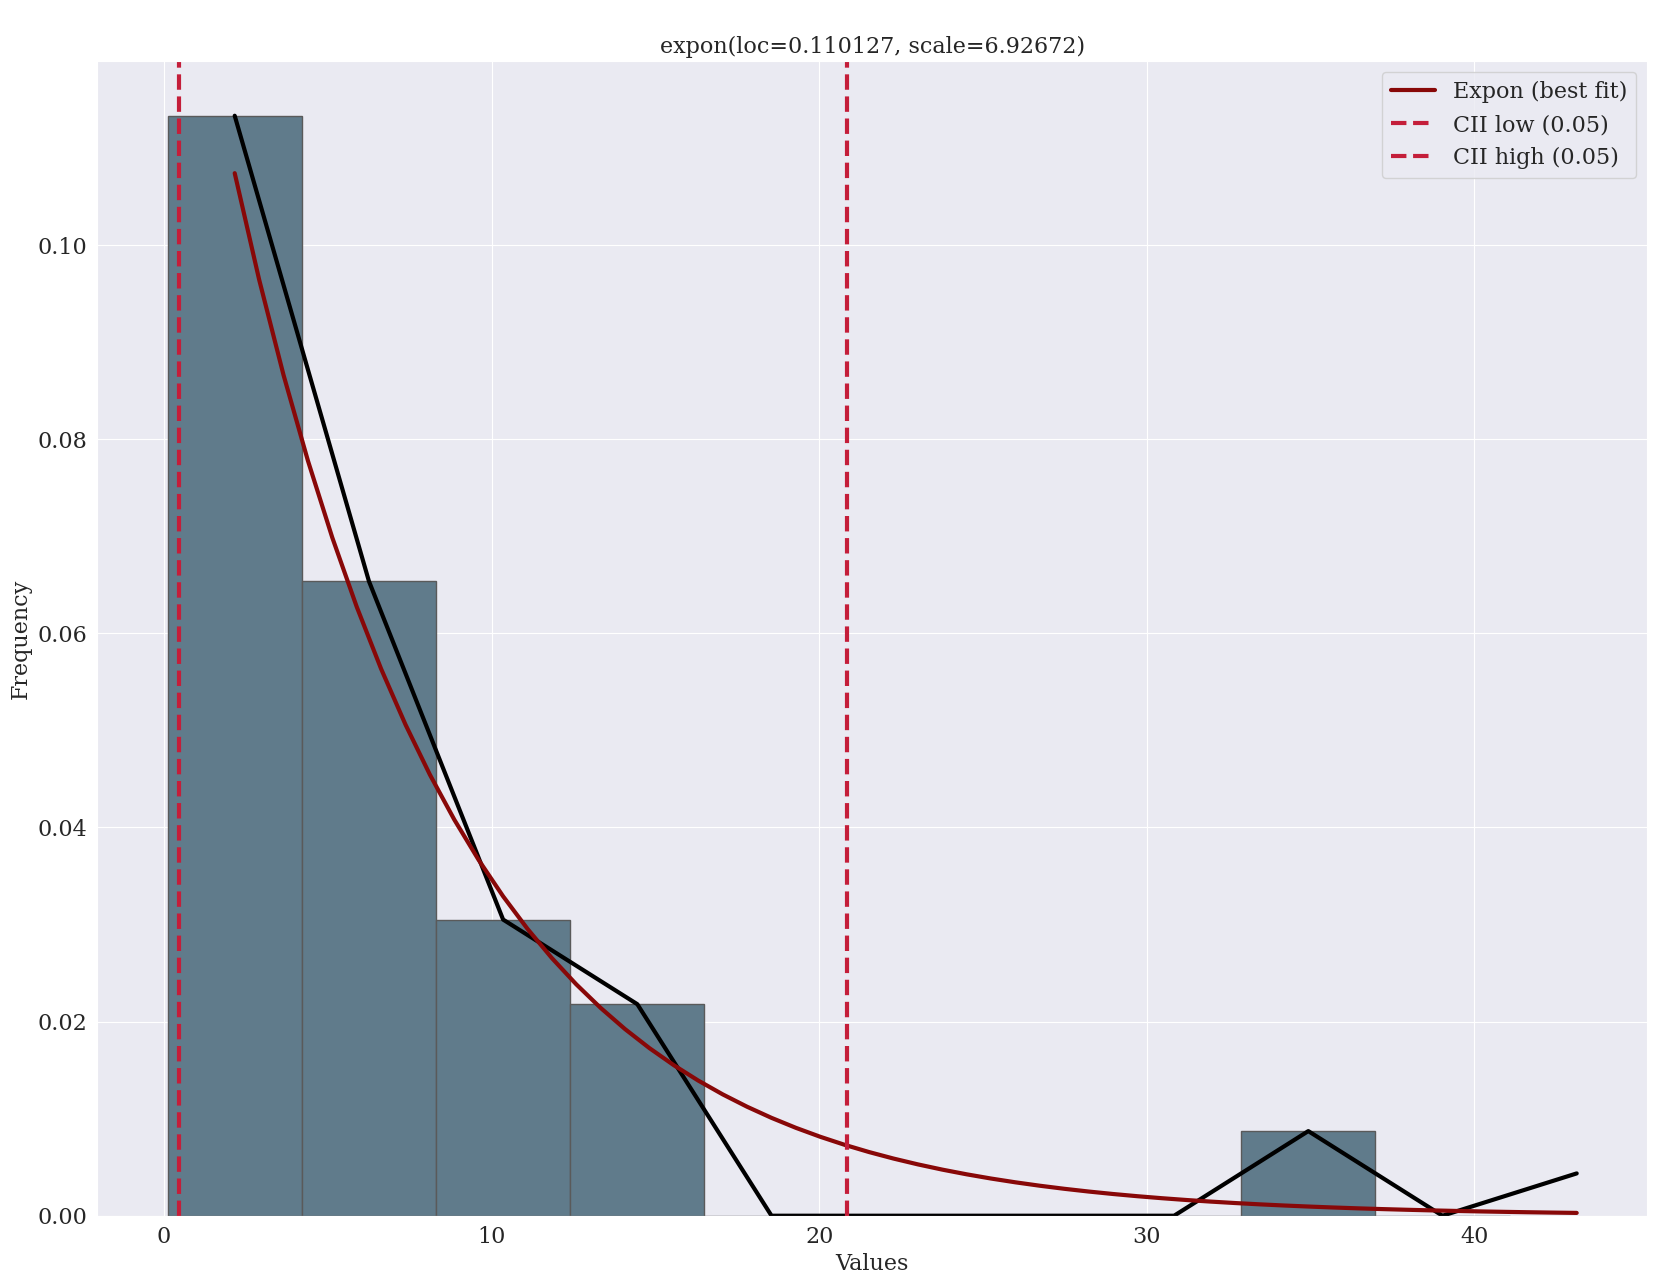

In [55]:
for row,(data,Nbins,x,y,sy,binwidth) in data_dict.items():
    fitting_minuit = MinuitFitFunctions(binwidth)

    xmin = min(data)
    xmax = max(data)
    fig, ax = plt.subplots(figsize=(16,5))
    counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Binned data uncertainty', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    initial_values_dict = {
        # 'N_exp':10000,
        # 'tau': 1/np.e,
        'N': 2000,
        'mu': np.log(50),
        'sigma': np.log(10),
        # 'N2': 1000,
        # 'mu2': np.log(140),
        # 'sigma2': np.log(10)
    }
    func_to_fit = fitting_minuit.N_log_gauss_pdf
    minuit_fit, fit_info = fitting_minuit.fit_chi2_minuit(func_to_fit,initial_values_dict,x,y,sy)

    pred_y = []
    for k in x:
        pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
    pred_y = np.array(pred_y)
    ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!


    d = {
     'Rule':      row[0],
     'Event from':      row[1],
     'Event to':     row[2],
    }
    to_print = {}
    pm = u"\u00B1"
    for k,v in minuit_fit.values.to_dict().items():
        to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
    d = {**d,**fit_info}
    d = {**d, **to_print}
    text = fit_human_in_the_loop.nice_string_output(d, extra_spacing=2, decimals=3)
    fit_human_in_the_loop.add_text_to_ax(0.5, 0.95, text, ax, fontsize=14)

    x_sampled, y_sampled = fitting_minuit.sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
    ax.scatter(x_sampled,y_sampled, s=.1, label='Uniform Sampled timings')

    ax.legend()
    fig.tight_layout()
    timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
    print(minuit_fit)
    plt.plot()
    fig, ax = plt.subplots(figsize=(16,5))

    f = Fitter(data, distributions=get_common_distributions(),xmax=800,timeout=2*60,bins=Nbins)
    f.fit()
    res = f.summary(plot=False)
    fitter_best_fit = res.iloc[0].name
    print(f.summary())
    print(f.get_best())
    print(next(iter(f.get_best())))
    fig.set_label(f'Rule {row[0]}: {row[1]} -> {row[2]}')
    # f.hist()
    f.plot_pdf()

    dist = distfit(distr='popular')  #full, popular, or a specific name
    dist.fit_transform(data)
    distfit_best_fit = dist.summary.iloc[0]['name']
    dist.plot()
    print(distfit_best_fit)

    gm = GaussianMixture(n_components=4, random_state=0).fit(data.reshape(-1,1))
    print(gm.means_)
    break

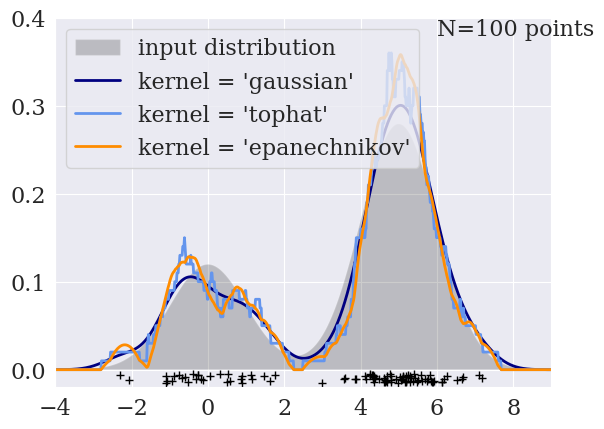

In [56]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

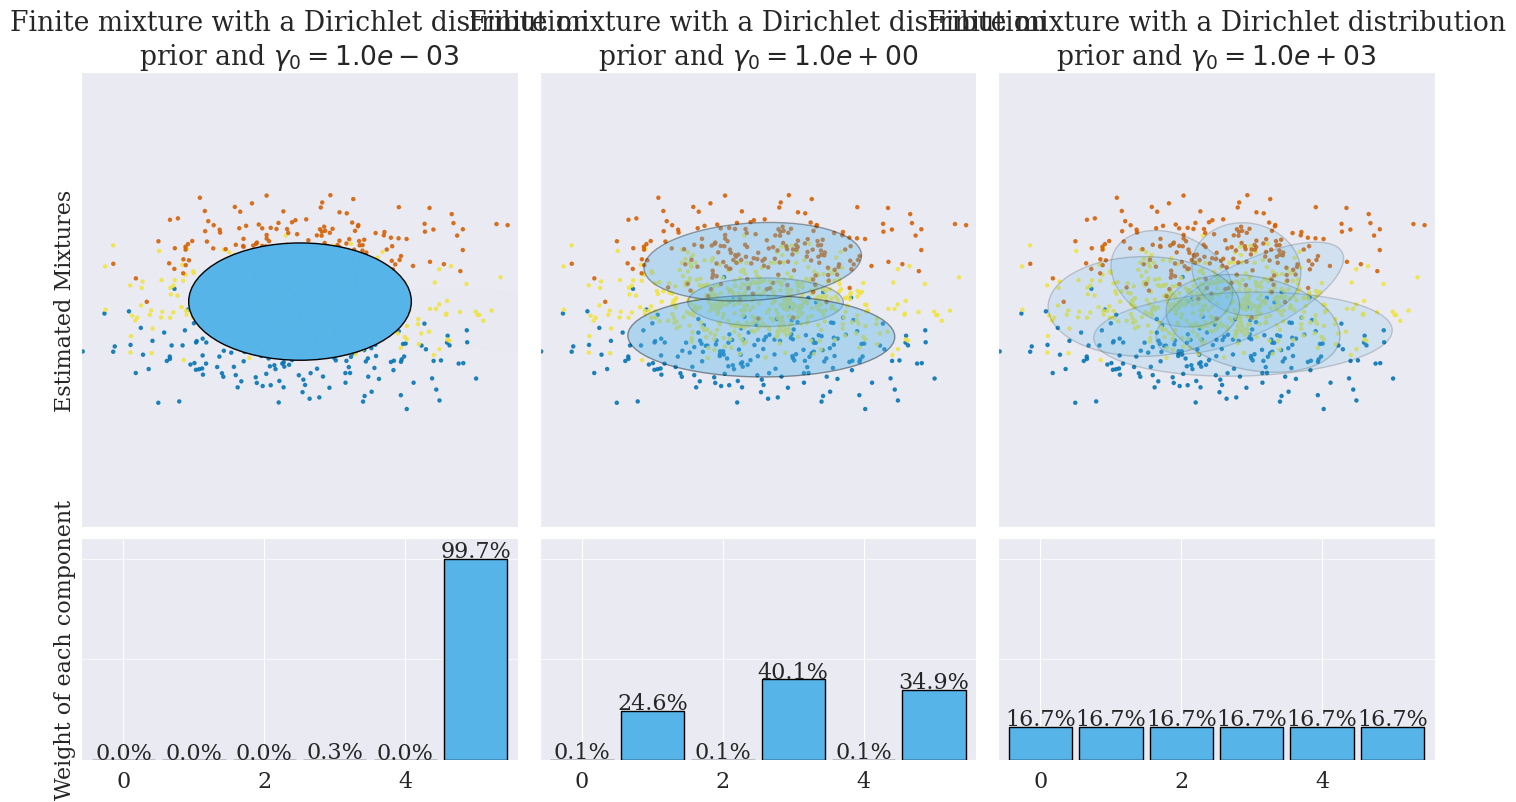

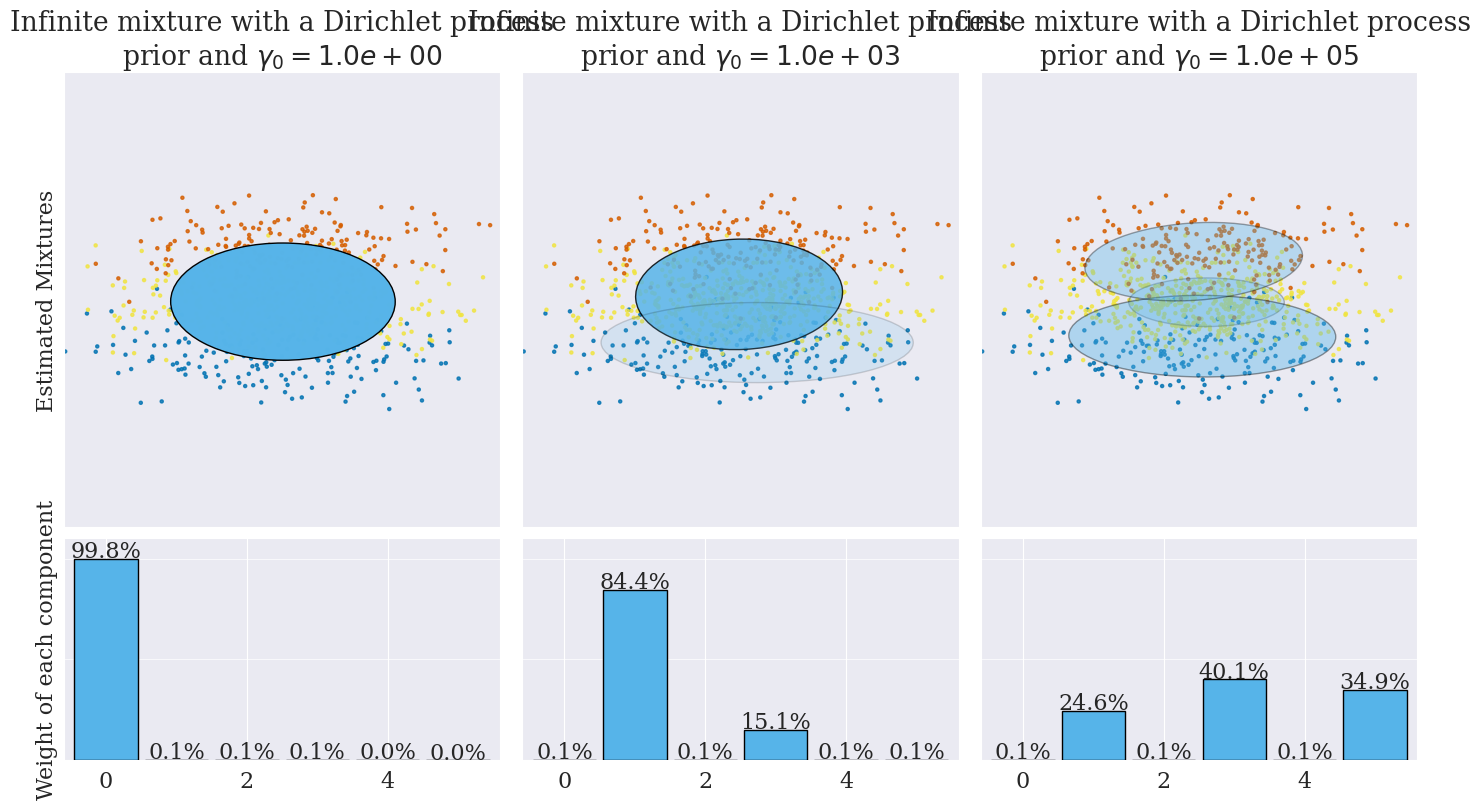

In [57]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import BayesianGaussianMixture


def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor("#56B4E9")
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color=colors[y], alpha=0.8)
    ax1.set_xlim(-2.0, 2.0)
    ax1.set_ylim(-3.0, 3.0)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0.0, 1.1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(["#0072B2", "#F0E442", "#D55E00"])

covars = np.array(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
samples = np.array([200, 500, 200])
means = np.array([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\n" r"prior and $\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n" r"prior and $\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack(
    [
        rng.multivariate_normal(means[j], covars[j], samples[j])
        for j in range(n_components)
    ]
)
y = np.concatenate([np.full(samples[j], j, dtype=int) for j in range(n_components)])

# Plot results in two different figures
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X,
            y,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()